# LightwaveExplorer Data Analyzation & Visualization
This jupyter notebook gives a few data 

In [1]:
#Import Python modules
import LightwaveExplorer as lwe
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt
import scipy as sp
import matplotlib
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 14

### Loading Simulation Data and Structure Analyzation

In [2]:
# Insert the path to your simulation results here
SiO2_1mm_xpol = lwe.load("LWE-results/fused-silica-1mm-50nJ-30THz-10000nmbeamwaist-xpol.zip")
SiO2_2mm_xpol = lwe.load("LWE-results/fused-silica-2mm-50nJ-30THz-10000nmbeamwaist-xpol.zip")
SiO2_1mm_circpol = lwe.load("LWE-results/fused-silica-1mm-50nJ-30THz-10000nmbeamwaist-circpol.zip")
Vac_1mm_xpol = lwe.load("LWE-results/vacuum-1mm-50nJ-30THz-10000nmbeamwaist-xpol.zip")

### Refractive Index

In [ ]:
#first we'll make a wavelength grid to work with
l = np.linspace(0.3,3,1024)

#next we'll need Sellmeier coefficients, these are for barium fluoride, H. H. Li., J. Phys. Chem. Ref. Data 9, 161-289 (1980)
a = lwe.getSellmeierFromRII("https://refractiveindex.info/database/data-nk/main/SiO2/Malitson.yml")
b = lwe.getSellmeierFromRII("https://refractiveindex.info/database/data-nk/main/BaF2/Malitson.yml")

#we can get the refractive index for the wavelengths we put in the grid by calling the sellmeier() function
#from the lightwaveExplorer module, with the equationType set to 0.
n = lwe.sellmeier(l, a, 0)
n2 = lwe.sellmeier(l, b, 0)

#let's make it so we can adjust the resonances of the oscillators and see how it affects the index

fig,ax = plt.subplots(1,1, figsize=(10,8))
ax.plot(l,np.real(n),label="SiO2",color="blue")
ax.plot(l,np.real(n2), label = "BaF2", color = "red")
ax.set_xlabel("Wavelength (" + r'$\mu$' + "m)")
ax.set_ylabel("Refractive index n")
plt.title("Refractive index of different materials")
ax.legend()
plt.savefig("graphs/refractive-index-SiO2-BaF2")
plt.show()

### On-Axis Electric Field

(1024,)
(1024,)
7.559475230740759
19.812344297409666
4.393089469191651


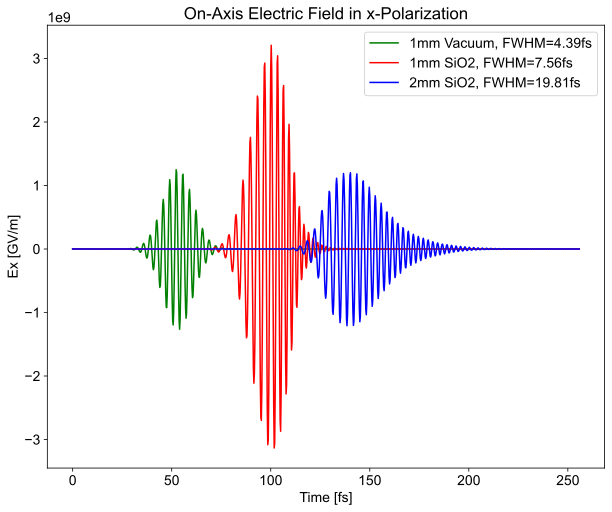

In [39]:
x = SiO2_1mm_xpol.timeVector * 1e15  # convert to fs
y1 = SiO2_1mm_xpol.Ext_x[:,87]       # select on-axis column
y2 = SiO2_2mm_xpol.Ext_x[:,87]
y3 = SiO2_1mm_circpol.Ext_x[:,87]
y4 = Vac_1mm_xpol.Ext_x[:,87]

print(x.shape)
print(y1.shape)
# FWHM's
print(lwe.fwhm(x, y1))
print(lwe.fwhm(x, y2))
print(lwe.fwhm(x, y4))

plt.figure(figsize=(10, 8))
plt.plot(x, y4, 'green', label='1mm Vacuum, FWHM=4.39fs')
plt.plot(x, y1, 'red', label='1mm SiO2, FWHM=7.56fs')
plt.plot(x, y2, 'blue', label='2mm SiO2, FWHM=19.81fs')
plt.xlabel('Time [fs]')
plt.ylabel('Ex [GV/m]')
plt.title('On-Axis Electric Field in x-Polarization')
plt.legend()
plt.savefig('graphs/electric-field')
plt.show()

### Energy Spectrum

In [ ]:
x = SiO2_1mm_xpol.frequencyVectorSpectrum / 1e12 # convert to THz
y1 = SiO2_1mm_xpol.spectrum_x
#y2 = SiO2_2mm_xpol.Ext_x[:,87]
#y3 = SiO2_1mm_circpol.Ext_x[:,87]
#y4 = Vac_1mm_xpol.Ext_x[:,87]

fig, ax1 = plt.subplots(figsize=(10,8))

color1 = 'tab:red'
ax1.set_xlabel('Frequency [Thz]')
ax1.set_ylabel('Sx linear [J/THz]', color=color1)
ax1.plot(x, y1, color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xlim((0,2000))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color2 = 'tab:blue'
ax2.set_ylabel('Sx log [J/THz]', color=color2)
ax2.set_yscale('log')
ax2.plot(x, y1, color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Resulting Energy Spectrum in x-Polarization')
plt.savefig('graphs/energy-spectrum')
plt.show()

In [ ]:
from scipy.fft import fft2

y = SiO2_1mm_xpol.frequencyVector / 1e12 # convert to THz
x = SiO2_1mm_xpol.spaceVector
print(x.shape)
z = np.abs(fft2(SiO2_1mm_xpol.Ext_x))
z_norma = lwe.norma(z)
z_log = 10 * np.log10(z / np.max(z))
#y2 = SiO2_2mm_xpol.Ext_x[:,87]
#y3 = SiO2_1mm_circpol.Ext_x[:,87]
#y4 = Vac_1mm_xpol.Ext_x[:,87]
print(z.shape)
X,Y = np.meshgrid(x,y)
Z=z_norma

plt.figure(figsize=(10,5))
plt.pcolormesh(Y,X,Z, shading="nearest", cmap='magma_r', norm=matplotlib.colors.LogNorm())
plt.xlabel("Frequency [THz]")
plt.ylabel("Position [" + r'$\mu$' + "m]")
plt.xlim((-2000,0))
plt.savefig("graphs/output")
plt.colorbar()
plt.show()



### Electric Field Grid

In [ ]:
result_electric_field_grid = lwe.load('LWE-results/fused-silica-1mm-50nJ-30THz-10000nmbeamwaist-circpol-electric-field-grid.zip')

y = result_electric_field_grid.timeVector * 1e15 # convert to fs
x = result_electric_field_grid.spaceVector * 1e6
print(x.shape)
z = result_electric_field_grid.Ext_x
#z_norma = lwe.norma(z)
#z = np.abs(fft2(SiO2_1mm_xpol.Ext_x))
#z_norma = lwe.norma(z)
#z_log = 10 * np.log10(z / np.max(z))
#y2 = SiO2_2mm_xpol.Ext_x[:,87]
#y3 = SiO2_1mm_circpol.Ext_x[:,87]
#y4 = Vac_1mm_xpol.Ext_x[:,87]
print(z.shape)
X,Y = np.meshgrid(x,y)
Z=z

# custom colormap that diverges from black in the middle
hue_neg, hue_pos = 260, 40
custom_cmap = sns.diverging_palette(hue_neg, hue_pos, center="dark", as_cmap=True)

plt.figure(figsize=(10,5))
plt.pcolormesh(Y,X,Z, shading="gouraud", cmap=custom_cmap) #norm=matplotlib.colors.LogNorm()
plt.xlabel("Time [fs]")
plt.ylabel("Position [" + r'$\mu$' + "m]")
#plt.xlim((-2000,0))
plt.title('Electric Field Grid Ex(x, y=0, t)')
clb = plt.colorbar()
clb.ax.set_title('Ex [GV/m]')
plt.savefig("graphs/electric-field-grid")
plt.close()

### Evolution of Spectrum as a function of propagation distance in the medium

In [78]:
#from scipy.fft import fft2

SiO2_batch = lwe.load("LWE-results/fused-silica-50nJ-30THz-10000nmbeamwaist-circpol-batch-0to500thickness-120steps.zip")
print(SiO2_batch.Ext_x.shape)
x = SiO2_batch.frequencyVectorSpectrum / 1e12 # convert to THz
print(x.shape)
#x = SiO2_1mm_xpol.spaceVector
y = SiO2_batch.batchVector * 1000   # convert to microns
print(y)
print(y.shape)
print(x)
z = SiO2_batch.spectrum_x
z_norma = lwe.norma(z)
print(z.shape)
#z = np.abs(fft2(SiO2_1mm_xpol.Ext_x))
#z_norma = lwe.norma(z)
#z_log = 10 * np.log10(z / np.max(z))
#y2 = SiO2_2mm_xpol.Ext_x[:,87]
#y3 = SiO2_1mm_circpol.Ext_x[:,87]
#y4 = Vac_1mm_xpol.Ext_x[:,87]
print(z.shape)
X,Y = np.meshgrid(x,y)
Z=z_norma

plt.figure(figsize=(10,5))
plt.pcolormesh(Y,X,Z, shading="gouraud", cmap='magma', norm=matplotlib.colors.LogNorm())
plt.xlabel("Position [" + r'$\mu$' + "m]")
plt.ylabel("Frequency [THz]")
#plt.ylim((0,00))
#plt.xlim((0,100))
plt.savefig("graphs/spectral-evolution-when-propagating")
plt.colorbar()
plt.close()


(512, 176, 120)
(257,)
[0.         0.00420168 0.00840336 0.01260504 0.01680672 0.0210084
 0.02521008 0.02941176 0.03361345 0.03781513 0.04201681 0.04621849
 0.05042017 0.05462185 0.05882353 0.06302521 0.06722689 0.07142857
 0.07563025 0.07983193 0.08403361 0.08823529 0.09243697 0.09663866
 0.10084034 0.10504202 0.1092437  0.11344538 0.11764706 0.12184874
 0.12605042 0.1302521  0.13445378 0.13865546 0.14285714 0.14705882
 0.1512605  0.15546218 0.15966387 0.16386555 0.16806723 0.17226891
 0.17647059 0.18067227 0.18487395 0.18907563 0.19327731 0.19747899
 0.20168067 0.20588235 0.21008403 0.21428571 0.21848739 0.22268908
 0.22689076 0.23109244 0.23529412 0.2394958  0.24369748 0.24789916
 0.25210084 0.25630252 0.2605042  0.26470588 0.26890756 0.27310924
 0.27731092 0.28151261 0.28571429 0.28991597 0.29411765 0.29831933
 0.30252101 0.30672269 0.31092437 0.31512605 0.31932773 0.32352941
 0.32773109 0.33193277 0.33613445 0.34033613 0.34453782 0.3487395
 0.35294118 0.35714286 0.36134454 0.36554

### Evolution of Spectrum as a function of puls energy

In [81]:
SiO2_batch_pulsenery = lwe.load("LWE-results/fused-silica-50nJ-30THz-10000nmbeamwaist-circpol-batch-1e-8to1e-7pulsenergy-100steps.zip")
print(SiO2_batch_pulsenery.Ext_x.shape)
x = SiO2_batch_pulsenery.frequencyVectorSpectrum / 1e12 # convert to THz
print(x.shape)
#x = SiO2_1mm_xpol.spaceVector
y = SiO2_batch_pulsenery.batchVector * 1e9  # convert to nJ
print(y)
print(y.shape)
print(x)
z = SiO2_batch_pulsenery.spectrum_x
z_norma = lwe.norma(z)
print(z.shape)
#z = np.abs(fft2(SiO2_1mm_xpol.Ext_x))
#z_norma = lwe.norma(z)
#z_log = 10 * np.log10(z / np.max(z))
#y2 = SiO2_2mm_xpol.Ext_x[:,87]
#y3 = SiO2_1mm_circpol.Ext_x[:,87]
#y4 = Vac_1mm_xpol.Ext_x[:,87]
print(z.shape)
X,Y = np.meshgrid(x,y)
Z=z_norma

plt.figure(figsize=(10,5))
plt.pcolormesh(Y,X,Z, shading="nearest", cmap='magma', norm=matplotlib.colors.LogNorm())
plt.xlabel("Pulse Energy [nJ]")
plt.ylabel("Frequency [THz]")
#plt.ylim((0,00))
#plt.xlim((0,100))
plt.title('Spectral Evolution with Pulse Energy')
plt.savefig("graphs/spectral-evolution-with-puls-energy-bigbatch")
plt.colorbar()
plt.close()

(320, 248, 100)
(161,)
[ 10.          10.90909091  11.81818182  12.72727273  13.63636364
  14.54545455  15.45454545  16.36363636  17.27272727  18.18181818
  19.09090909  20.          20.90909091  21.81818182  22.72727273
  23.63636364  24.54545455  25.45454545  26.36363636  27.27272727
  28.18181818  29.09090909  30.          30.90909091  31.81818182
  32.72727273  33.63636364  34.54545455  35.45454545  36.36363636
  37.27272727  38.18181818  39.09090909  40.          40.90909091
  41.81818182  42.72727273  43.63636364  44.54545455  45.45454545
  46.36363636  47.27272727  48.18181818  49.09090909  50.
  50.90909091  51.81818182  52.72727273  53.63636364  54.54545455
  55.45454545  56.36363636  57.27272727  58.18181818  59.09090909
  60.          60.90909091  61.81818182  62.72727273  63.63636364
  64.54545455  65.45454545  66.36363636  67.27272727  68.18181818
  69.09090909  70.          70.90909091  71.81818182  72.72727273
  73.63636364  74.54545455  75.45454545  76.36363636  77.2727

### Pulse width Evolution

In [ ]:
SiO2_batch_pulswidth = lwe.load("LWE-results/fused-silica-50nJ-30THz-10000nmbeamwaist-circpol-batch-0to500thickness-120steps.zip")
print(SiO2_batch_pulswidth.Ext_x.shape)
print(SiO2_batch_pulswidth.Ext_x[:,87,:].shape)
temp = []
for n in range(len(SiO2_batch_pulswidth.batchVector)):
    temp.append(lwe.fwhm(SiO2_batch_pulswidth.timeVector, SiO2_batch_pulswidth.Ext_x[:,87,n]))
  #np.append(pulswidths, lwe.fwhm(SiO2_batch_pulswidth.timeVector, SiO2_batch_pulswidth.Ext_x[:,87,n]))
temp = np.array(temp)
print(SiO2_batch_pulswidth.Ext_x[:,87,1].shape)
print(temp.shape)
#pulswidths = lwe.fwhm(SiO2_batch_pulswidth.timeVector, temp) #SiO2_batch_pulswidth.Ext_x[:,87,:])

#print(pulswidths.shape)
#print(lwe.fwhm(SiO2_batch_pulswidth.timeVector, SiO2_batch_pulswidth.Ext_x[:,87,1]))
x = SiO2_batch_pulswidth.batchVector
print(len(SiO2_batch_pulswidth.batchVector))
print(temp)
plt.title('Evolution of Pulse Width with Propagation Depth')
plt.plot(x,temp,'red')
plt.close()

### Bandwidth Evolution

In [83]:
SiO2_batch_bandwidth = lwe.load("LWE-results/fused-silica-50nJ-30THz-10000nmbeamwaist-circpol-batch-0to500thickness-120steps.zip")
#print(SiO2_batch_pulswidth.Ext_x.shape)
#print(SiO2_batch_pulswidth.Ext_x[:,87,:].shape)
temp = []
for n in range(len(SiO2_batch_pulswidth.batchVector)):
    temp.append(lwe.fwhm(SiO2_batch_pulswidth.frequencyVectorSpectrum, SiO2_batch_bandwidth.spectrumTotal[n,:]))
  #np.append(pulswidths, lwe.fwhm(SiO2_batch_pulswidth.timeVector, SiO2_batch_pulswidth.Ext_x[:,87,n]))
temp = np.array(temp) / 1e12 # conversion to THz
#print(SiO2_batch_pulswidth.Ext_x[:,87,1].shape)
#print(temp.shape)
#pulswidths = lwe.fwhm(SiO2_batch_pulswidth.timeVector, temp) #SiO2_batch_pulswidth.Ext_x[:,87,:])
print(SiO2_batch_bandwidth.spectrumTotal.shape)
x = SiO2_batch_pulswidth.batchVector * 1e6  # conversion to microns
#y = lwe.fwhm(x, SiO2_batch_bandwidth.spectrumTotal[:])
#print(pulswidths.shape)
#print(lwe.fwhm(SiO2_batch_pulswidth.timeVector, SiO2_batch_pulswidth.Ext_x[:,87,1]))
#print(len(SiO2_batch_pulswidth.batchVector))
#print(temp)
plt.figure(figsize=(10,5))
plt.plot(x,temp,'red')
plt.xlabel("Position [" + r'$\mu$' + "m]")
plt.ylabel("FWHM [THz]")
plt.title('Bandwidth Evolution with Propagation Depth')
plt.savefig('graphs/bandwidth-evolution-test')
plt.close()

(120, 257)


In [ ]:
n = 1.4504                                          # refractive index for fused silica
x = results.spaceVector
y = results.frequencyVectorSpectrum  # wavelength values for x-axis
#y = np.linspace(0,(sp.constants.c * n / results.frequencyVector)[161], num=1024)    #reverse data
z = (results.Ext_x**2)[:513] #lwe.normaM(results.Ext_x)
z_normalized = lwe.norma(z)

y[0] = y[1]                                     # fix 0 value for y[0]
print(x.shape)
print(y.shape)
print(z.shape)
print(sp.constants.c)
#print(results.frequencyVector[:161])
print(y[:161])
#print(y)

X,Y = np.meshgrid(x,y)
Z=z_normalized

#plt.xlim(-10, 10)

plt.figure(figsize=(5,10))
plt.pcolormesh(X,Y,Z, shading='flat', norm=matplotlib.colors.LogNorm()) #shading='gouraud'
plt.xlabel("position x [m]")
plt.ylabel("time t [s]")
#plt.yscale('log', base=10)
plt.savefig("graphs/output")
plt.show()

In [ ]:
n = 1.4504
x =  results.frequencyVectorSpectrum / 1e12#[::-1] #sp.constants.c * n/
y1 = results.spectrum_x
y2 = results.spectrum_x
x[0] = x[1]
print(x.shape)
print(y2)
print(y2.shape)

fig, ax1 = plt.subplots()

color1 = 'tab:red'
ax1.set_xlabel('Frequency [Thz]')
ax1.set_ylabel('Spectrum linear [J/THz]', color=color1)
ax1.plot(x, y1, color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xlim((0,1000))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color2 = 'tab:blue'
ax2.set_ylabel('Spectrum log [dB]', color=color2)  # we already handled the x-label with ax1
ax2.set_yscale('log')
ax2.plot(x, y2, color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

"""
plt.xlim((0,1000000000000000))
plt.yscale('log')
plt.ylabel('log')

plt.plot(x,y)
plt.show()"""